## Foreach, future.apply and Load Balancing
In this chapter, you will look at two user-contributed packages, namely foreach and future.apply, which make parallel programming in R even easier. They are built on top of the parallel and future packages. In the last lesson of this chapter, you will learn about the advantages and pitfalls of load balancing and scheduling.

### Word frequency with foreach
Recall the first chapter where you found the most frequent words from the janeaustenr package that are of certain minimum length. It looked like this:

result <- lapply(letters, max_frequency, words = words, min_length = 5) %>% unlist

In this exercise, you will implement the foreach construct to solve the same problem.

Warning message:
"package 'janeaustenr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"

package 'foreach' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Migue\AppData\Local\Temp\RtmpAtOanJ\downloaded_packages


Warning message:
"package 'foreach' was built under R version 3.6.3"

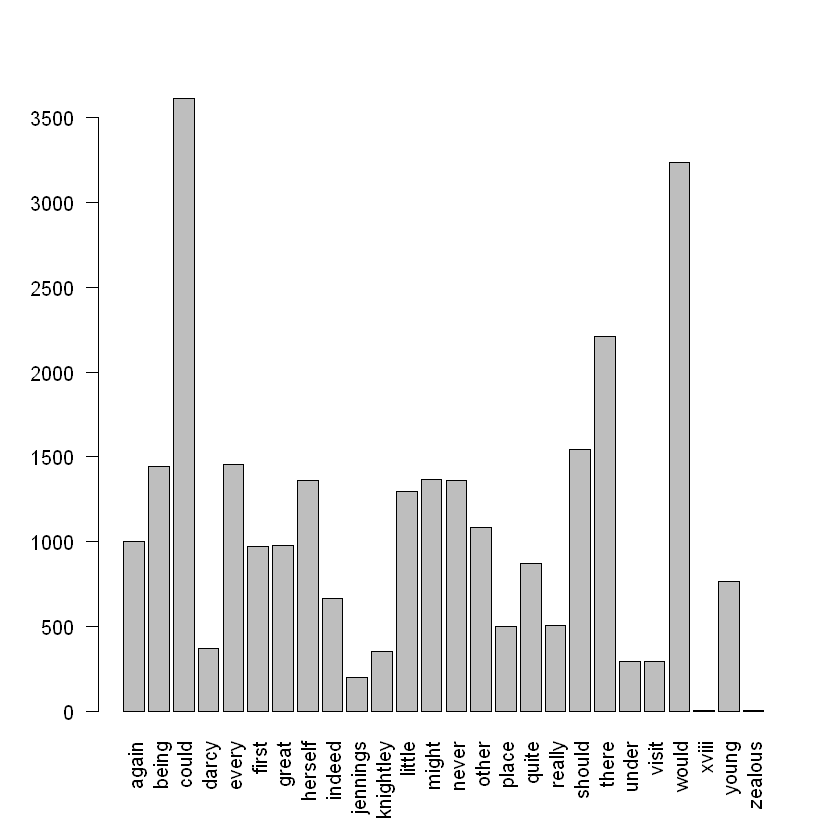

In [1]:
library(janeaustenr)
library(stringr)
library(readr)
library(tidyr)

extract_words <- function(book_name){
    # extract the text of the book
    text <- subset(austen_books(), book == book_name)$text
    # extract words from the text and convert to lowercase
    str_extract_all(text, boundary("word")) %>% unlist %>% tolower
}

janeausten_words <- function() {
    # Names of the six books contained in janeaustenr
    books <- austen_books()$book %>% unique %>% as.character
    # Vector of words from all six books
    words <- sapply(books, extract_words) %>% unlist
    words
}
# Vector of words from all six books
words <- janeausten_words()


select_words <- function(letter, words, min_length = 1) {
    min_length_words <- words[nchar(words) >= min_length]
    grep(paste0("^", letter), min_length_words, value = TRUE)
}

max_frequency <- function(letter, words, min_length = 1) {
    w <- select_words(letter, words = words, min_length = min_length)
    frequency <- table(w)    
    frequency[which.max(frequency)]
}


letters = c("a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p",
            "q","r","s", "t", "u", "v", "w", "x", "y", "z")

# Load the package
# install.packages("foreach")
library(foreach)

# foreach() %do% construct
result <- foreach(let = letters, .combine = c) %do% 
                max_frequency(let, words, min_length = 5)
                
# Plot results 
barplot(result, las = 2)

### Multiple iterators in word frequency
This exercise is a modification of the previous one. Now assume you want to vary the minimum word length across the letters of the alphabet. Specifically, your job is to modify the code so that the maximum frequency for the first half of the alphabet is obtained for words that are two and more characters long, while the frequency corresponding to the second half of the alphabet is derived from words that are six and more characters long. Note that we are using an alphabet of 26 characters.

Your namespace has all the objects from the previous exercise, plus the foreach package is loaded.

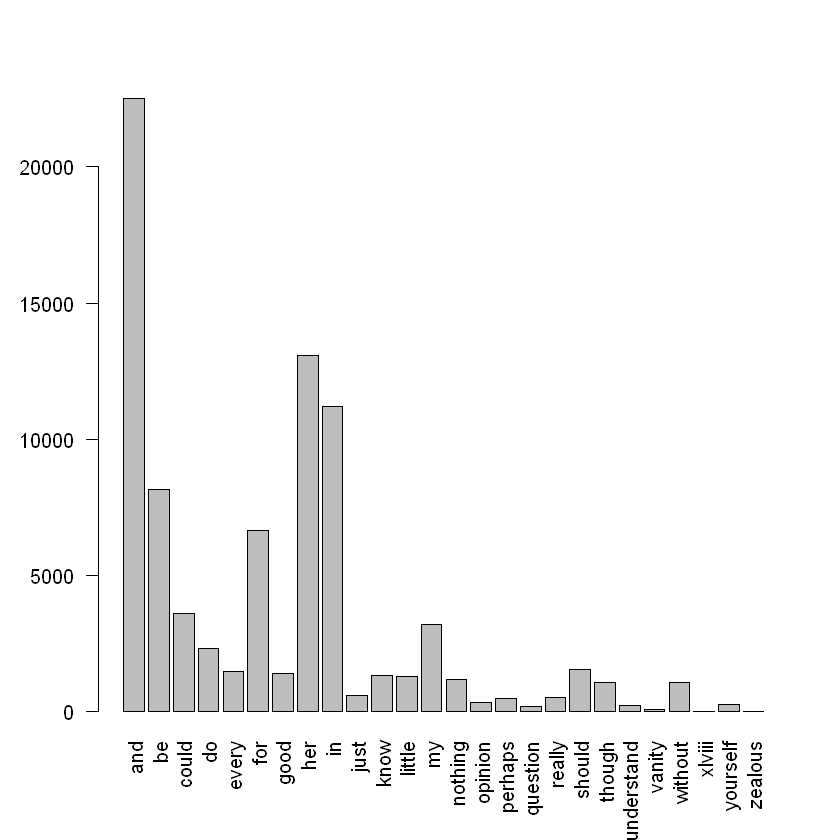

In [13]:
# hint. Use the iterator n to define multiple values of the min_length argument. 
# It is equal to 2 in the first 13 iterations and equal to 6 in the last 13 iterations. 
# Use c() and rep() to construct n so that it has the same length as let.

# foreach()%do% construct with 2 iterators
result <- foreach(let = letters, n = c(rep(2, 13), rep(6,13)) , .combine = c) %do%
                max_frequency(let, words, min_length = n)
            
# Plot results
barplot(result, las = 2)

# define  a function
freq_seq <- function(min_length = 5)
    foreach(let = letters, .combine=c) %do% 
        max_frequency(let, words = words, min_length = min_length)

### Using doParallel
In one of the previous exercises, you parallelized the function myrdnorm() which uses the package extraDistr to generate discrete random numbers. Here you will implement a parallel foreach solution to the same problem, using the doParallel backend. doParallel provides an argument .packages which ensures that external packages are loaded on all nodes.

In [5]:
# install.packages("doParallel")
library(doParallel)

# Pre-defined myrdnorm 
myrdnorm <- function(n, mean = 0, sd = 1) 
    rnorm(n, mean = mean, sd = sd)

# Register doParallel with 3 cores
registerDoParallel(cores = 3)

# foreach()%dopar% loop
res <- foreach(r = rep(1000, 100), .combine = rbind, 
            .packages = "extraDistr") %dopar% myrdnorm(r)
            
# Dimensions of res
dim_res <-  dim(res)

Warning message:
"package 'doParallel' is in use and will not be installed"

### Word frequency with doParallel
So far you learned how to search for the most frequent word in a text sequentially using foreach(). In the course of the next two exercises, you will implement the same task using doParallel and doFuture for parallel processing and benchmark it against the sequential version. The sequential solution is implemented in function freq_seq() (type freq_seq in your console to see it). It iterates over a global character vector chars and calls the function max_frequency() which searches within a vector of words, while filtering for minimum word length. All these objects are preloaded, as is the doParallel package. Your job now is to write a function freq_doPar() that runs the same code in parallel via doParallel.

In [6]:
# Function for doParallel foreach
freq_doPar <- function(cores, min_length = 5) {
    # Register a cluster of size cores
    registerDoParallel(cores = cores)
    
    # foreach loop
    foreach(let = letters, .combine = c, 
            .export = c("max_frequency", "select_words", "words"),
            .packages = c("janeaustenr", "stringr")) %dopar%
        max_frequency(let, words = words, min_length = min_length)
}

# Run on 2 cores
freq_doPar(2)

again     being     could     darcy     every     first     great   herself 
     1001      1445      3613       373      1456       972       981      1360 
   indeed  jennings knightley    little     might     never     other     place 
      664       199       356      1295      1369      1362      1084       503 
    quite    really    should     there     under     visit     would     xviii 
      870       504      1541      2209       293       294      3238         4 
    young   zealous 
      766         5

### Word frequency with doFuture and benchmarking
Now your job is to create a function freq_doFut() that accomplishes the same task as freq_doPar() but with the doFuture backend. Note that when using doFuture, arguments .packages and .export in foreach() are not necessary, as the package deals with the exports automatically.

You will then benchmark these two functions, together with the sequential freq_seq(). All the functions from the last exercise are available in your workspace. In addition, the packages doFuture and microbenchmark are also preloaded. To keep the computation time low, the global chars vector is set to the first six letters of the alphabet only.

In [17]:
# install.packages("doFuture")
library(doFuture)
# Function for doFuture foreach
freq_doFut <- function(cores, min_length = 5) {
    # Register and set plan
    registerDoFuture()
    plan(cluster, workers = cores)
    
    # foreach loop
    foreach(let = letters, .combine = c) %dopar% 
        max_frequency(let, words = words, min_length = min_length)
}

# start Benchmark 
library (microbenchmark)
cores = 2
min_length = 6


# Benchmark
microbenchmark(freq_seq(min_length), 
               freq_doPar(cores, min_length), 
               freq_doFut(cores, min_length),
               times = 1)

# In this example, you should not see any time advantage in running it in parallel. 
# In addition, doFuture is usually somewhat slower than doParallel. This is because doFuture has a higher computation overhead. 
# We encourage you to test these frameworks on more time-consuming applications 
# where an overhead become negligible relative to the overall processing time.

Warning message:
"package 'doFuture' was built under R version 3.6.3"Loading required package: future
Warning message:
"package 'future' was built under R version 3.6.3"

expr,time
"freq_doPar(cores, min_length)",3163988500
freq_seq(min_length),3820980000
"freq_doFut(cores, min_length)",3829757500


### Word frequency with future.apply
In the spirit of the last slide, imagine you are a package developer. You will now code the main function of your package, a function that for each given letter finds the maximum frequency in a set of words that starts with that letter and is at least a given length long. It is the same task as in our last exercise, except that now you will use the future.apply package and apply it to the Barack Obama's State of the Union address in 2016.

The package future.apply and functions max_frequency() and extract_words_from_text() are available in your workspace. The dataset is called obama_speech.

In [24]:
# install.packages("future")
library(future)
library(stringr)
library(readr)
library(tidyr)


obama_speech = read_file("SOTU.txt")

extract_words_from_text <- function(text) {
    # extract words from the text and convert to lowercase
    str_extract_all(text, boundary("word")) %>% unlist %>% tolower
}

# Main function
freq_fapply <- function(words, chars = letters, min_length = 5) {
    unlist(
        future_lapply(chars, max_frequency, words = words, 
                         min_length = min_length)
    )
}

# Extract words
words <- extract_words_from_text(obama_speech)

# Call the main function
res <- freq_fapply(words)

# Plot results
barplot(res, las = 2)

# IMPORTANT: The future_lapply() function has been moved to the future.apply package. 
# The version in this package (future) is defunct and gives an error if used. It will be fully removed in an upcoming release. 

ERROR: Error in future_lapply(chars, max_frequency, words = words, min_length = min_length): could not find function "future_lapply"


### Load balancing
You will now test the effect of load balancing in a situation with uneven task processing times. We create such situation by applying the sleep function on the workers side to a heterogeneous set of run times.

In your workspace there is a vector tasktime containing simulated processing times of 30 tasks (generated using runif()). There is also a cluster object cl with two nodes.

Your job is to apply the function Sys.sleep() to tasktime in parallel using clusterApply() and clusterApplyLB() and benchmark them. The parallel and microbenchmark packages are loaded. We also provided functions for plotting cluster usage plots called plot_cluster_apply() and plot_cluster_applyLB(). Both functions use functionality from the snow package.

package 'snow' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Migue\AppData\Local\Temp\RtmpAtOanJ\downloaded_packages



Attaching package: 'snow'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster



expr,time
"clusterApplyLB(cl, tasktime, Sys.sleep)",7267632000
"clusterApply(cl, tasktime, Sys.sleep)",8809289500


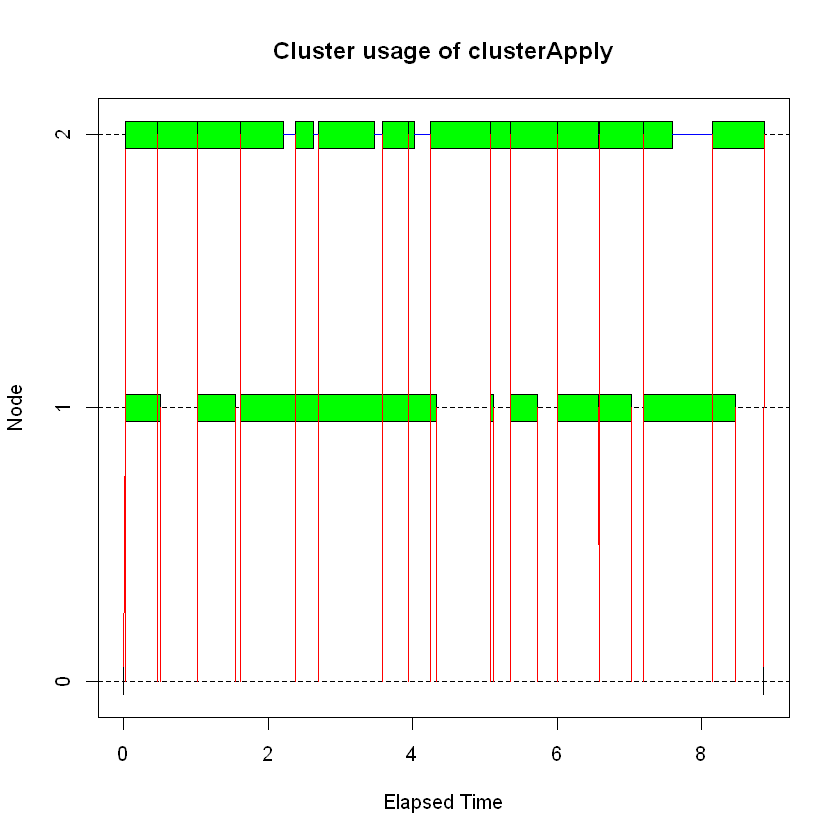

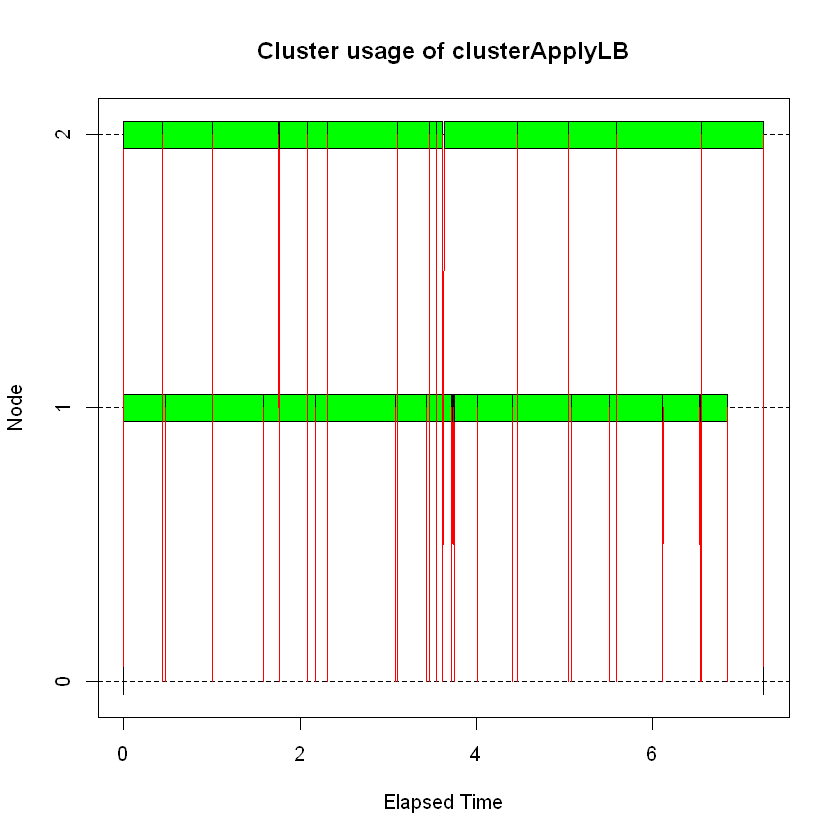

In [27]:
install.packages("snow")
library(snow)

# Create a cluster
cl <- makeCluster(2)
tasktime = runif(30)

plot_cluster_apply <- function(cl, x, fun) {
    plot(snow::snow.time(snow::clusterApply(cl, x, fun)),
            title = "Cluster usage of clusterApply")
}

plot_cluster_applyLB <- function(cl, x, fun){
    plot(snow::snow.time(snow::clusterApplyLB(cl, x, fun)),
            title = "Cluster usage of clusterApplyLB")
}

# Benchmark clusterApply and clusterApplyLB
microbenchmark(
    clusterApply(cl, tasktime, Sys.sleep),
    clusterApplyLB(cl, tasktime, Sys.sleep),
    times = 1
)

# Plot cluster usage
plot_cluster_apply(cl, tasktime, Sys.sleep)
plot_cluster_applyLB(cl, tasktime, Sys.sleep)

# Even though the run time here depends on the current load of the DataCamp server,
# I hope you were able to see at least some time improvements when using load balancing.

### Scheduling
Now we compare the results from the previous exercise with ones generated using parSapply(), which represents here an implementation that groups tasks into as many chunks as there are workers available. You first explore its cluster usage plot, using the function plot_parSapply() we defined for you. We generated a version of the tasktime vector, called bias_tasktime that generates very uneven load. Your job is to compare the run times of parSapply() with clusterApplyLB() applied to bias_tasktime.

All objects from the previous exercise are in your workspace.

expr,time
"parSapply(cl, bias_tasktime, Sys.sleep)",3392920300
"clusterApplyLB(cl, bias_tasktime, Sys.sleep)",2381139000


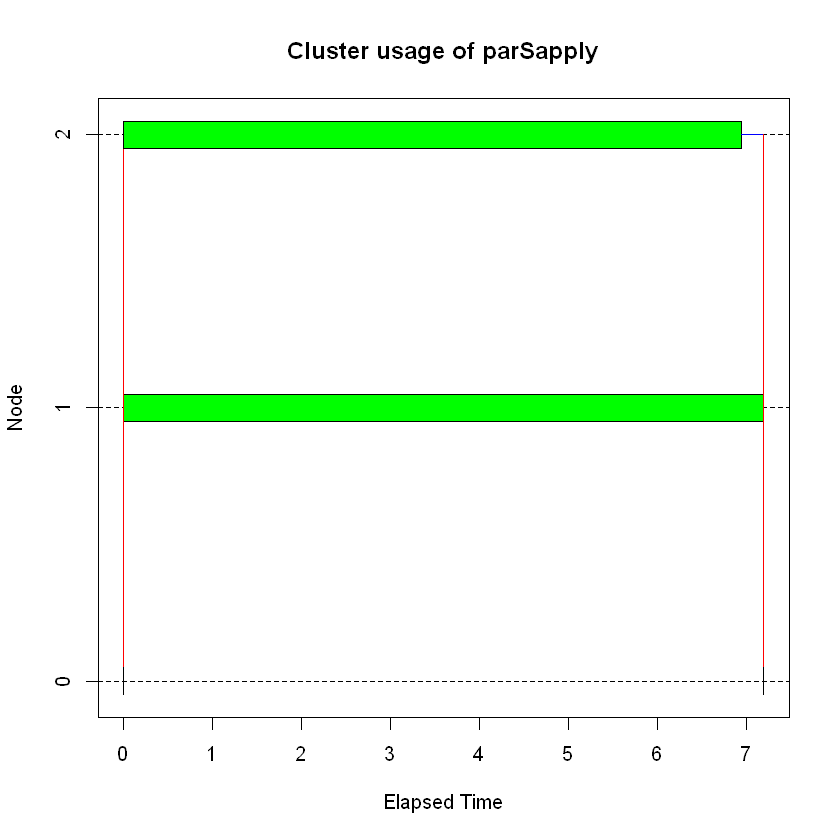

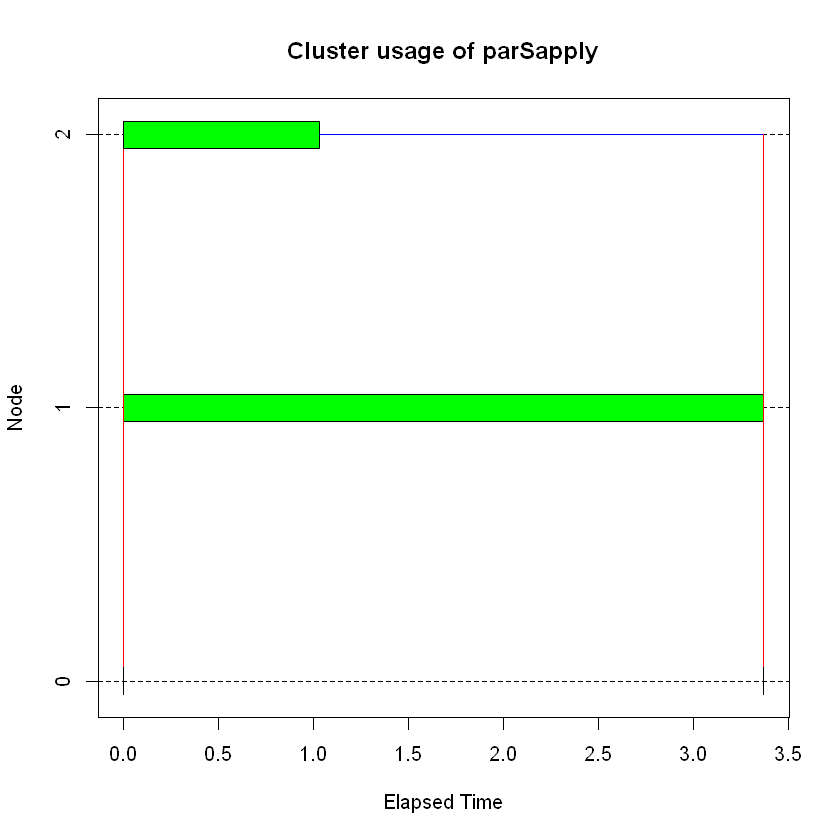

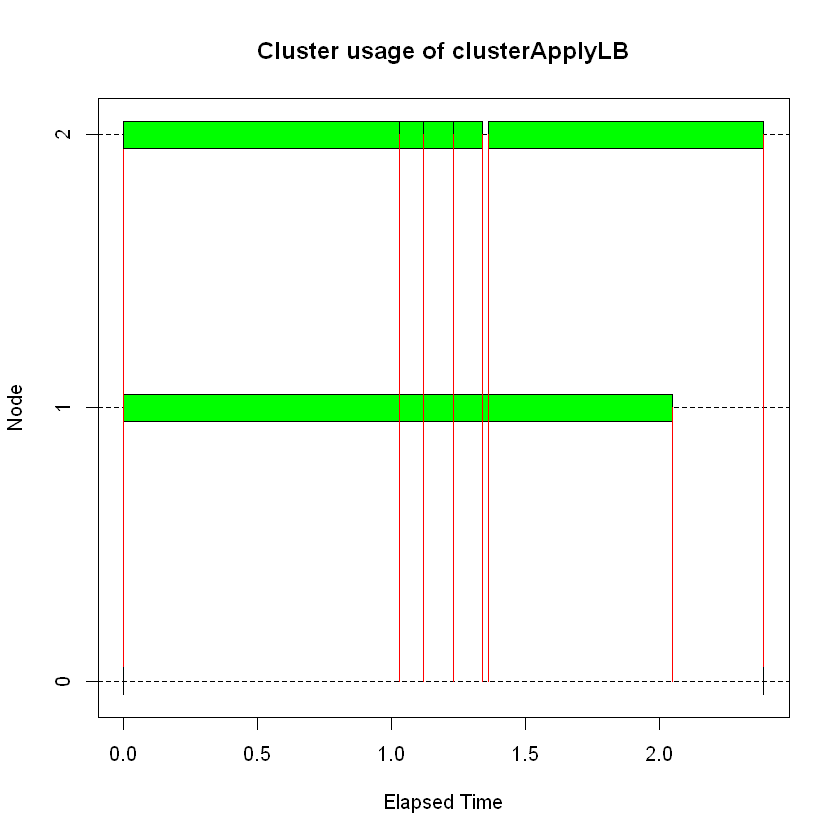

In [29]:
bias_tasktime = c(1e+00, 1e+00, 1e+00, 1e-01, 1e-01, 1e-01, 1e-04, 1e-04, 1e-04, 1e-03, 1e+00)

plot_parSapply <- function(cl, x, fun) 
    plot(snow::snow.time(snow::parSapply(cl, x, fun)),
            title = "Cluster usage of parSapply")

# Plot cluster usage for parSapply
plot_parSapply(cl, tasktime, Sys.sleep)

# Microbenchmark
microbenchmark(
    clusterApplyLB(cl, bias_tasktime, Sys.sleep),
    parSapply(cl, bias_tasktime, Sys.sleep),
    times = 1
)

# Plot cluster usage for parSapply and clusterApplyLB
plot_parSapply(cl, bias_tasktime, Sys.sleep)
plot_cluster_applyLB(cl, bias_tasktime, Sys.sleep)

# The function parSapply() minimizes the communication by creating one chunk per worker. 
# However, when there is an uneven task load, load balancing can be more efficient.